In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
class Upproject(nn.Module):
    def __init__(self, in_channels, out_channels): #residual preserves map sizes, reduces channels
        super(Upproject, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=5, stride=1, padding=2, bias=False) #p=0
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                               kernel_size=3, stride=1, padding=1, bias=False) #p=1
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=5, stride=1, padding=2, bias=False) #p=0
        self.batchnorm3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out1 = F.relu(self.batchnorm1(self.conv1(x)))
        out1 = self.batchnorm2(self.conv2(out1))
        out2 = self.batchnorm3(self.conv3(x))
        
        out = F.relu(out1 + out2)
        return out

class Upconv(nn.Module): 
    def __init__(self, in_channels, out_channels): #only upsamples map sizes.
        super(Upconv, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=2, stride=2, padding=0, bias=False)
        
    def forward(self, x):
        out = self.deconv(x)
        return out


In [3]:
outputs = []
def hook(module, input, output):
    outputs.append(output)

resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-2] #remove final fc layer
encoder=nn.Sequential(*modules)
encoder[4].register_forward_hook(hook)
encoder[5].register_forward_hook(hook)
encoder[6].register_forward_hook(hook)

x = torch.randn(4, 3, 192, 640)
y = encoder(x)
print(outputs[0].shape, outputs[1].shape, outputs[2].shape)
print(y.shape)

torch.Size([4, 256, 48, 160]) torch.Size([4, 512, 24, 80]) torch.Size([4, 1024, 12, 40])
torch.Size([4, 2048, 6, 20])


In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.skip_outputs = []

        resnet50 = models.resnet50(pretrained=True)
        modules=list(resnet50.children())[:-2] #remove final fc layer & avgpool layer
        self.encoder=nn.Sequential(*modules)
        
        self.encoder[4].register_forward_hook(self.hook)
        self.encoder[5].register_forward_hook(self.hook)
        self.encoder[6].register_forward_hook(self.hook)

        #Decoder
        self.conv2 = nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(1024)
        
        self.upconv1 = Upconv(1024,1024)
        self.up1 = Upproject(1024,512)
        
        self.upconv2 = Upconv(512,512)
        self.upconv_skip2 = Upconv(1024,512)
        self.up2 = Upproject(512,256)

        self.upconv3 = Upconv(256,256)
        self.upconv_skip3 = Upconv(512,256)
        self.up3 = Upproject(256,128)

        self.upconv4 = Upconv(128,128)
        self.upconv_skip4 = Upconv(256,128)
        self.up4 = Upproject(128,64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        
    def hook(self, module, input, output):
        self.skip_outputs.append(output)

    def forward(self, x):
        self.skip_outputs = [] #clear every time

        x = self.encoder(x)
        x = F.relu(self.batchnorm2(self.conv2(x))) #torch.Size([n, 1024, 12, 40])

        x = self.upconv1(x)
        x = self.up1(x) #torch.Size([n, 512, 24, 80])

        x = self.upconv2(x)
        s = self.upconv_skip2(self.skip_outputs[2])
        x = self.up2(x + s) #torch.Size([n, 256, 48, 160])

        x = self.upconv3(x)
        s = self.upconv_skip3(self.skip_outputs[1])
        x = self.up3(x + s) #torch.Size([n, 128, 96, 320])

        x = self.upconv4(x)
        s = self.upconv_skip4(self.skip_outputs[0])
        x = self.up4(x + s) #torch.Size([n, 64, 192, 640])

        x = F.sigmoid(self.conv3(x)) #torch.Size([n, 1, 192, 640])
        return x

In [5]:
model = Network()
x = torch.randn(4, 3, 192, 640)
output = model(x)
y = torch.randn(4, 3, 192, 640)
output = model(y)

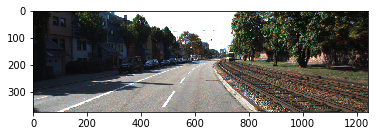

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

###Double input###
train_dir = '/data/KITTI/KITTI_RAW/2011_09_26/2011_09_26_drive_0001_sync/'
left_view_dir = train_dir + 'image_02'
right_view_dir = train_dir + 'image_03'

sample_img = mpimg.imread(left_view_dir+'/data/0000000000.png')
plt.imshow(sample_img)
plt.show() #dims = (375, 1242, 3)

In [7]:
transform = transforms.Compose([transforms.Resize((192,640)), # 389,1285
                                    transforms.ToTensor()])
left_train_dataset = datasets.ImageFolder(left_view_dir, transform)
right_train_dataset = datasets.ImageFolder(left_view_dir, transform)

train_loader = DataLoader(dataset=left_train_dataset, batch_size=10, shuffle=False)

iter_X = iter(train_loader)
images_X, _ = iter_X.next()

In [8]:
model = Network()
y_hat = model(images_X)
y_hat.shape

torch.Size([10, 1, 96, 320])